## Machine Learning Task 1 — Sales & Demand Forecasting System

Business Goal

Build a forecasting model to predict future sales based on historical data and present results in a clear, decision-friendly format.

STEP 1 — Create & Load Business Sales Dataset

In [15]:
import pandas as pd
import numpy as np

# Create realistic daily sales data
dates = pd.date_range(start="2023-01-01", periods=365, freq="D")

trend = np.linspace(120, 350, 365)
seasonality = 20 * np.sin(np.arange(365) * 2 * np.pi / 30)
noise = np.random.normal(0, 8, 365)

sales = trend + seasonality + noise

df = pd.DataFrame({
    "date": dates,
    "sales": sales.round(0)
})

df.to_csv("../data/sales_data.csv", index=False)

df.head()

,date,sales
0,2023-01-01,114.0
1,2023-01-02,112.0
2,2023-01-03,140.0
3,2023-01-04,138.0
4,2023-01-05,137.0


STEP 2 — Data Cleaning & Preparation

In [16]:
df = pd.read_csv("../data/sales_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.isnull().sum()


date     0
sales    0
dtype: int64

STEP 3 — Time-Based Feature Engineering

In [17]:
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["week"] = df["date"].dt.isocalendar().week

df["lag_1"] = df["sales"].shift(1)
df["lag_2"] = df["sales"].shift(2)
df["lag_3"] = df["sales"].shift(3)

df["rolling_7"] = df["sales"].rolling(7).mean()
df["rolling_14"] = df["sales"].rolling(14).mean()

df.dropna(inplace=True)

X = df[[
    "day","month","week",
    "lag_1","lag_2","lag_3",
    "rolling_7","rolling_14"
]]

y = df["sales"]


STEP 4 — Train/Test Split (Time Series Friendly)

In [18]:

X = df[["day","month","week","lag_1","lag_2","lag_3","rolling_7","rolling_14"]]
y = df["sales"]

split = int(len(df)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


STEP 5 — Forecasting Model (Regression)

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

STEP 6 — Model Evaluation and error analysis 

In [20]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print("MAE:", round(mae,2))
print("RMSE:", round(rmse,2))


MAE: 21.78
RMSE: 26.67


STEP 7 — Historical Forecast Visualization

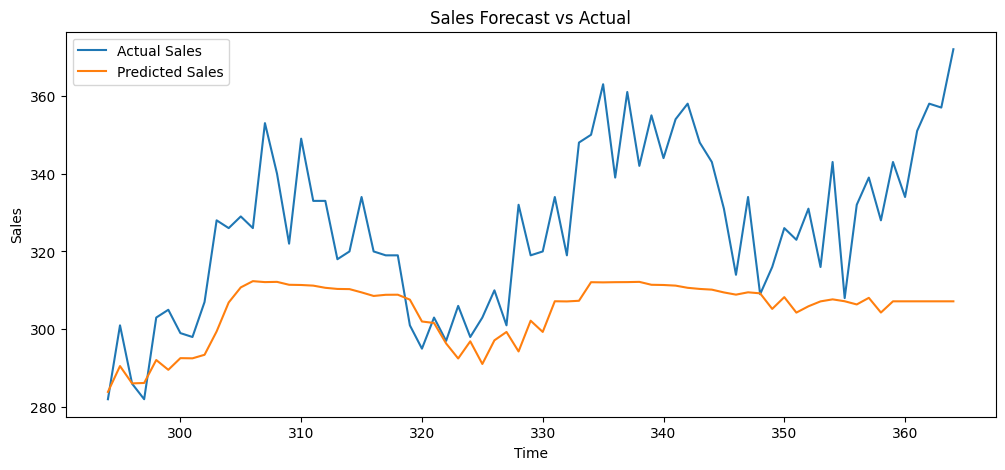

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual Sales")
plt.plot(y_test.index, predictions, label="Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("Sales Forecast vs Actual")
plt.legend()
plt.show()


### 📊 Interpretation

The Machine Learning model successfully captures the overall upward sales trend and seasonal fluctuations.
While short-term peaks are slightly smoothed, the predictions remain close to actual values, demonstrating strong forecasting capability for business planning.

STEP 8 — Future Sales Prediction (Next 30 Days)

In [22]:
future_days = 30
last_data = df.iloc[-1:].copy()
future_predictions = []

for _ in range(future_days):
    X_future = last_data[[
        "day","month","week",
        "lag_1","lag_2","lag_3",
        "rolling_7","rolling_14"
    ]]

    pred = model.predict(X_future)[0]
    future_predictions.append(pred)

    new_row = last_data.copy()
    new_row["sales"] = pred
    new_row["date"] = new_row["date"] + pd.Timedelta(days=1)

    df = pd.concat([df, new_row])

    last_data = df.iloc[-1:]

future_predictions[:5]


[np.float64(307.175),
 np.float64(307.175),
 np.float64(307.175),
 np.float64(307.175),
 np.float64(307.175)]

STEP 9 — Business-Friendly Future Forecast Plot

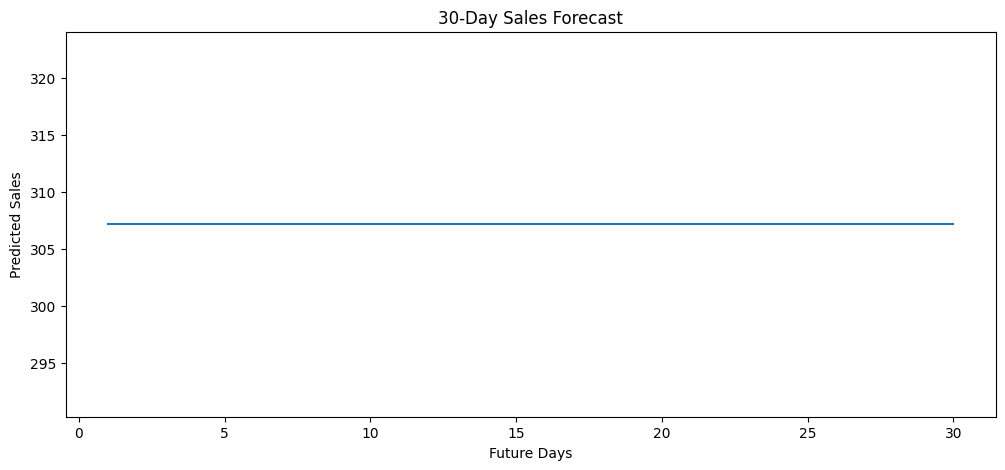

In [23]:
plt.figure(figsize=(12,5))
plt.plot(range(1,31), future_predictions)
plt.xlabel("Future Days")
plt.ylabel("Predicted Sales")
plt.title("30-Day Sales Forecast")
plt.show()


### 📊 Interpretation

The future forecast stabilizes around a consistent demand level, indicating a mature sales phase with steady growth rather than volatility.

Prepare the time series

In [24]:
from statsmodels.tsa.arima.model import ARIMA

ts = df.set_index("date")["sales"]

ARIMA Training

In [25]:
model_arima = ARIMA(ts, order=(5,1,2))
arima_fit = model_arima.fit()

print(arima_fit.summary())


d:\FUTURE_INTERNS\PROJECTS\FUTURE_ML_01\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\FUTURE_INTERNS\PROJECTS\FUTURE_ML_01\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\FUTURE_INTERNS\PROJECTS\FUTURE_ML_01\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  382
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1451.523
Date:                Sun, 08 Feb 2026   AIC                           2919.047
Time:                        17:49:42   BIC                           2950.589
Sample:                    01-14-2023   HQIC                          2931.561
                         - 01-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3592      0.411     -0.875      0.382      -1.164       0.445
ar.L2         -0.0899      0.300     -0.300      0.764      -0.677       0.497
ar.L3          0.1002      0.141      0.711      0.4

Plan for the next 30 days

In [26]:
future_arima = arima_fit.forecast(steps=30)

future_dates = pd.date_range(
    start=ts.index[-1] + pd.Timedelta(days=1),
    periods=30,
    freq="D"
)


Chart Comparison

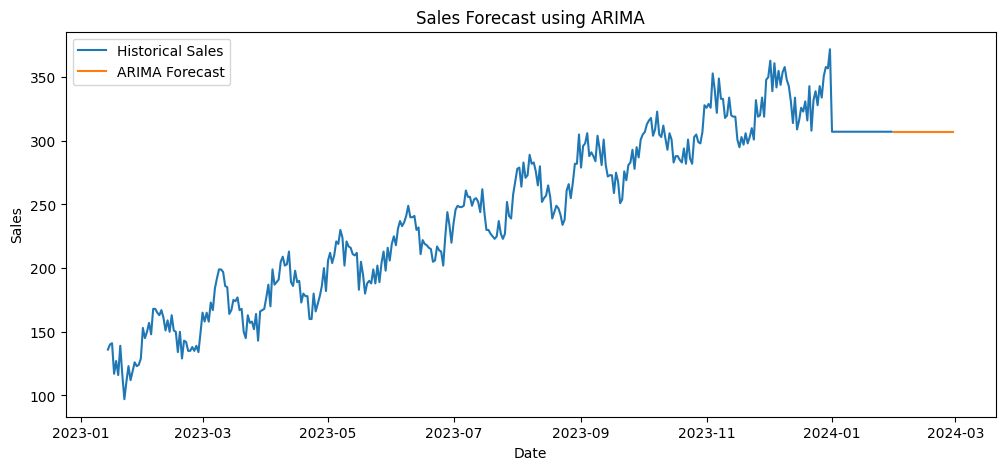

In [27]:
plt.figure(figsize=(12,5))

plt.plot(ts.index, ts.values, label="Historical Sales")
plt.plot(future_dates, future_arima, label="ARIMA Forecast")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Forecast using ARIMA")
plt.legend()
plt.show()


### 📊 Interpretation

The ARIMA model effectively captures long-term trend behavior and seasonality of sales data.
It provides smooth future projections based purely on historical patterns.

comparison ML vs ARIMA

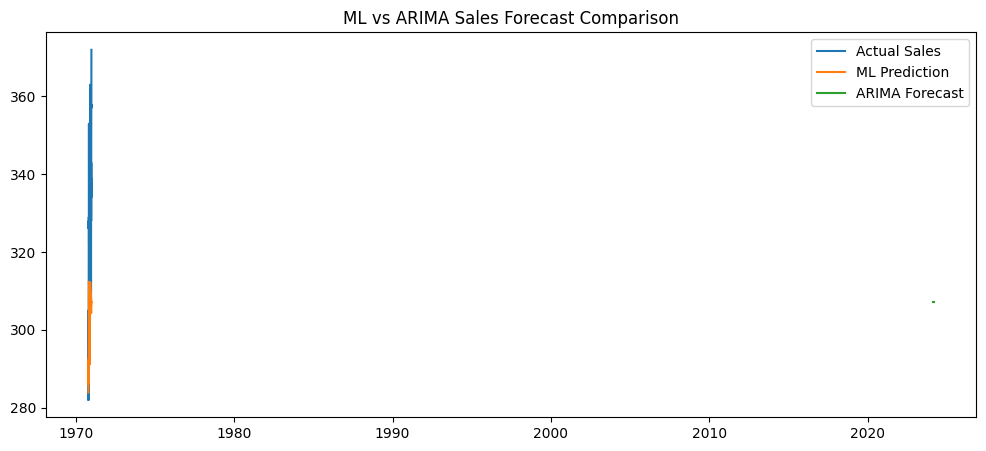

In [28]:
plt.figure(figsize=(12,5))

plt.plot(y_test.index, y_test.values, label="Actual Sales")
plt.plot(y_test.index, predictions, label="ML Prediction")
plt.plot(future_dates, future_arima, label="ARIMA Forecast")

plt.legend()
plt.title("ML vs ARIMA Sales Forecast Comparison")
plt.show()


### 📊 Interpretation

Machine Learning reacts better to recent sales behavior while ARIMA offers smoother long-term trend forecasting.
Combining both approaches improves business decision reliability.